In [1]:
import numpy as np
import pandas as pd
from dside import DSI
import matplotlib.pyplot as plt
import GPy
from smt.sampling_methods import LHS
from kernel_opt_fun import *

In [ ]:

#Generate LHS training samples
xlimits = np.array([
    [20,50],
    [1,10], 
    [20,50],
    [0.1, 60]
])
sampling = LHS(xlimits=xlimits, criterion='ese')

n = 100
x_LHS = sampling(n)

# Define the objective function
def f(X):
    
    return 8.61 * np.exp(5) * X[:, 0]**(1/2) * X[:, 1] * X[:, 2]**(-2) * X[:, 3]**(-1/2) +  3.69 * np.exp(4) * X[:, 2] + 7.72 * np.exp(8) * X[:, 0]**(-1) * X[:, 1]**0.219 - 765.43 * np.exp(6) * X[:, 0]**(-1)

# Create input X arrays
X1 = x_LHS[:,0]
X2 = x_LHS[:,1]
X3 = x_LHS[:,2]
X4 = x_LHS[:,3]


In [ ]:
X = np.vstack((X1.flatten(), X2.flatten(), X3.flatten(), X4.flatten())).T
Y = f(X).reshape(-1, 1)

# Create and train the GP model
best_kernel, best_mea = find_best_kernel(X, Y, input_dim=4)
print("Best kernel:", kernel_to_str(best_kernel))
print("Best MEA:", best_mea)

model = GPy.models.GPRegression(X, Y, best_kernel)


In [4]:

# Fit the model
model.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0004   6.262729e+02   6.616363e+00 
    00s18  0015   6.262011e+02   3.300554e-02 

 C:\Users\lm3223\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s20  0017   6.262011e+02   1.165141e-02 
Runtime:     00s20
Optimization status: Converged



In [5]:


# Re-generate sample points for plotting (finer grid)
n = 20
X1 = np.linspace(20, 50, n)
X2 = np.linspace(1, 10, n)
X3 = np.linspace(20, 50, n)
X4 = np.linspace(0.1, 60, n)
X1, X2, X3, X4 = np.meshgrid(X1, X2, X3, X4)
X = np.vstack((X1.flatten(), X2.flatten(), X3.flatten(), X4.flatten())).T
Y = f(X).reshape(-1, 1)

# Step 4: Predict
X_pred = X
Y_pred, Y_pred_var = model.predict(X_pred)

# Reshape for plotting
Y_pred = Y_pred.reshape(X1.shape)
Y_true = f(X_pred).reshape(X1.shape)



In [6]:
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_absolute_percentage_error 

MAE = mean_absolute_error(Y, Y_pred.reshape(-1, 1))
MAPE = mean_absolute_percentage_error(Y, Y_pred.reshape(-1, 1))
print(f"MAE = {MAE:.3f}")
#print(f"MAPE = {MAPE*100:.2f}%")


MAE = 27.876
MAPE = 3.86%


In [7]:
# Calculate the percentage of small values baaed on Ytrue
threshold = 1e-3
percentsmallY = percentage_small_values(Y, threshold)

print(f"Percentage of small true values (|Y_true| < {threshold}): {percentsmallY:.2f}%")
# Calculate custom MAPE
custom_MAPE = custom_mape(Y, Y_pred.reshape(-1, 1))
print(f"Custom MAPE = {custom_MAPE:.2f}%")
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
R2score = r2_score(Y, Y_pred.reshape(-1, 1))
MSE = mean_squared_error(Y, Y_pred.reshape(-1, 1))
print(f"R2 = {R2score:.2f}")
print(f"MSE = {MSE:.5f}")

Percentage of small true values (|Y_true| < 0.001): 0.00%
Custom MAPE = 3.86%
R2 = 1.00
MSE = 2854.49821


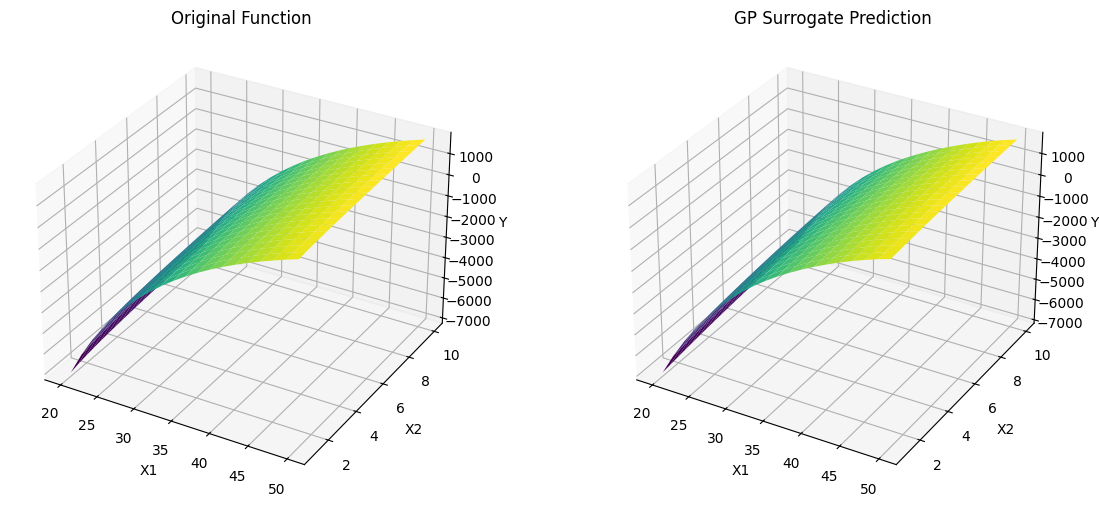

In [8]:
# Note: Plotting a 3D surface is not directly possible for 4D data (X1, X2, X3, Y).
# So we will plot slices or projections. Here we plot a slice where X3 is fixed.

# Select fixed slices for X3 and X4 for visualization
slice_index_X3 = n // 2
slice_index_X4 = n // 2
X1_slice = X1[:, :, slice_index_X3, slice_index_X4]
X2_slice = X2[:, :, slice_index_X3, slice_index_X4]
Y_true_slice = Y_true[:, :, slice_index_X3, slice_index_X4]
Y_pred_slice = Y_pred[:, :, slice_index_X3, slice_index_X4]

# Plotting
fig = plt.figure(figsize=(14, 6))

# Original data
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1_slice, X2_slice, Y_true_slice, cmap='viridis')
ax1.set_title('Original Function')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('Y')

# Surrogate model prediction
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X1_slice, X2_slice, Y_pred_slice, cmap='viridis')
ax2.set_title('GP Surrogate Prediction')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('Y')

plt.show()

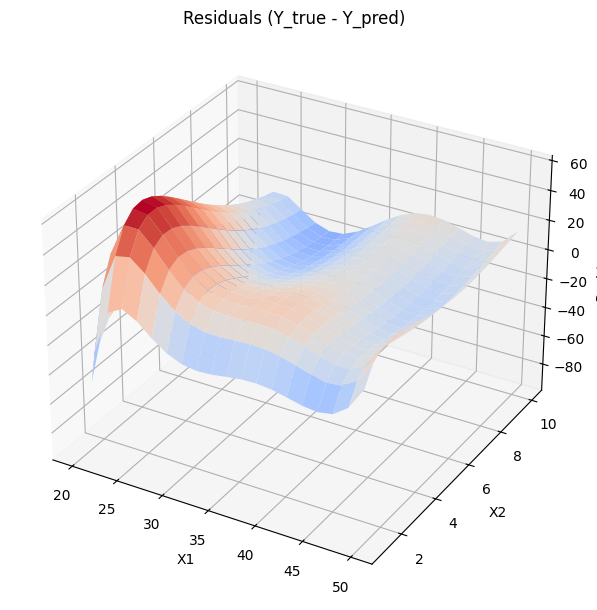

In [9]:
# Calculate residuals
residuals = Y_true_slice - Y_pred_slice

# # Plotting
#fig = plt.figure(figsize=(14, 6))
fig = plt.figure(figsize=(25,25), dpi=100)

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1_slice, X2_slice, residuals, cmap='coolwarm')
ax1.set_title('Residuals (Y_true - Y_pred)')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('Residuals')
plt.subplots_adjust(left=0.1, right=0.6, top=0.85, bottom=0.15)
plt.show()

In [10]:
# Flatten the arrays
X1_flat = X1.flatten()
X2_flat = X2.flatten()
X3_flat = X3.flatten()
X4_flat = X4.flatten()
Y_true_flat = Y_true.flatten()
Y_pred_flat = Y_pred.flatten()

# Create a DataFrame
data = {
    'X1': X1_flat,
    'X2': X2_flat,
    'X3': X3_flat,
    'X4': X4_flat,
    'Y_true': Y_true_flat,
    'Y_pred': Y_pred_flat,
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

          X1    X2    X3         X4        Y_true       Y_pred
0       20.0   1.0  20.0   0.100000 -10214.653444 -9809.894005
1       20.0   1.0  20.0   3.252632 -10251.910211 -9869.202087
2       20.0   1.0  20.0   6.405263 -10254.186839 -9905.060872
3       20.0   1.0  20.0   9.557895 -10255.210671 -9929.629724
4       20.0   1.0  20.0  12.710526 -10255.824543 -9953.221310
...      ...   ...   ...        ...           ...          ...
159995  50.0  10.0  50.0  47.389474   4664.763438  4646.719337
159996  50.0  10.0  50.0  50.542105   4664.597056  4659.947494
159997  50.0  10.0  50.0  53.694737   4664.445552  4681.310173
159998  50.0  10.0  50.0  56.847368   4664.306832  4713.575936
159999  50.0  10.0  50.0  60.000000   4664.179195  4759.471464

[160000 rows x 6 columns]


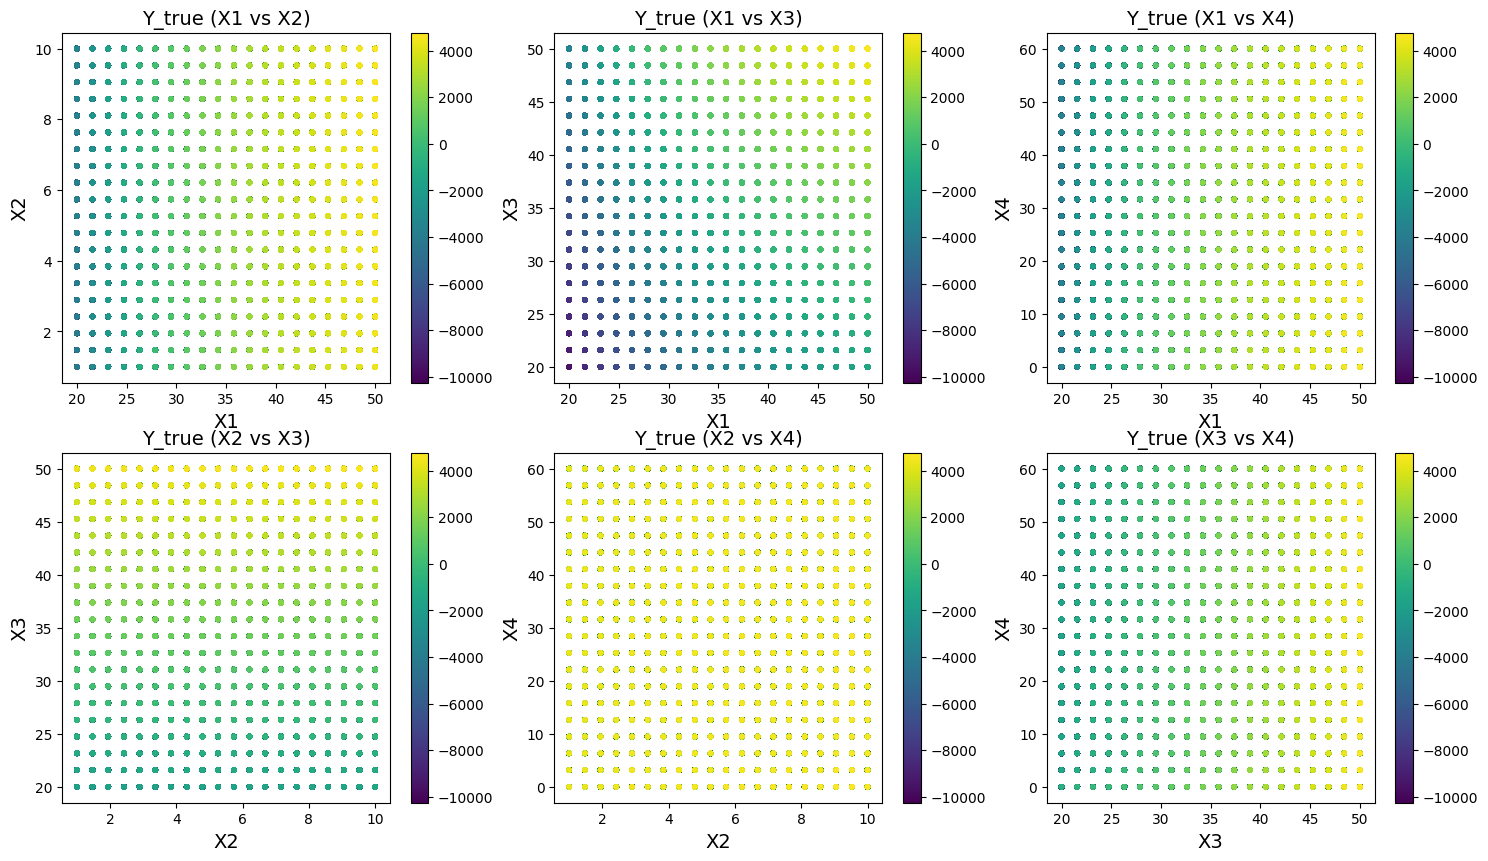

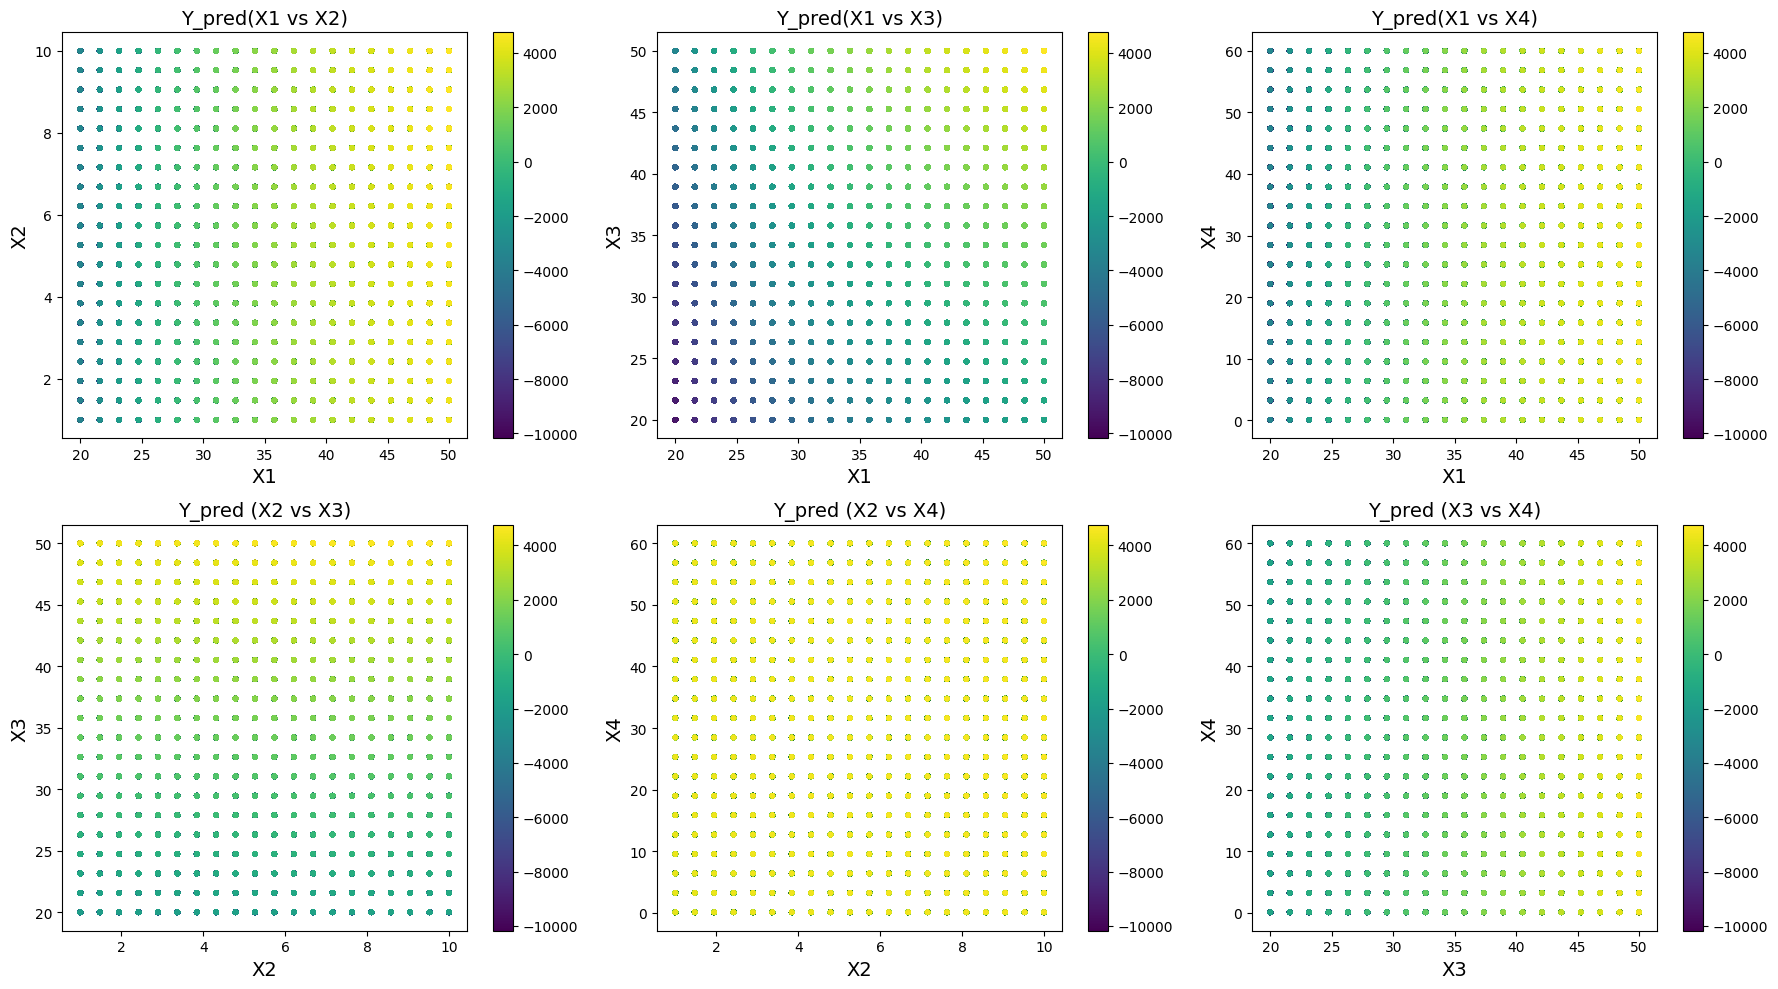

In [11]:

import matplotlib.pyplot as plt

# Assuming df contains X1, X2, X3, X4, Y_true, and Y_pred
fig, ax = plt.subplots(2,3, figsize=(18, 10))  # 2 rows, 4 columns layout for 6 plots
fs = 14

# List of variable pairs to plot
pairs = [('X1', 'X2'), ('X1', 'X3'), ('X1', 'X4'),
         ('X2', 'X3'), ('X2', 'X4'),('X3', 'X4')]

# Plotting combinations for Y_true

for i, (x_var, y_var) in enumerate(pairs):
    if  i<3:
        sc = ax[0, i].scatter(df[x_var], df[y_var], c=df['Y_true'], marker='.', cmap='viridis')
        cbar = fig.colorbar(sc, ax=ax[0, i])
        ax[0, i].set_title(f'Y_true ({x_var} vs {y_var})', fontsize=fs)
        ax[0, i].set_xlabel(x_var, fontsize=fs)
        ax[0, i].set_ylabel(y_var, fontsize=fs)
    else: 
        sc = ax[1, i-3].scatter(df[x_var], df[y_var], c=df['Y_true'], marker='.', cmap='viridis')
        cbar = fig.colorbar(sc, ax=ax[1, i-3])
        ax[1, i-3].set_title(f'Y_true ({x_var} vs {y_var})', fontsize=fs)
        ax[1, i-3].set_xlabel(x_var, fontsize=fs)
        ax[1, i-3].set_ylabel(y_var, fontsize=fs)

fig, ax = plt.subplots(2,3, figsize=(18, 10))  # 2 rows, 4 columns layout for 6 plots
fs = 14


# # Plotting combinations for Y_pred
for i, (x_var, y_var) in enumerate(pairs):
    if  i<3:
        sc = ax[0, i].scatter(df[x_var], df[y_var], c=df['Y_pred'], marker='.', cmap='viridis')
        cbar = fig.colorbar(sc, ax=ax[0, i])
        ax[0, i].set_title(f'Y_pred({x_var} vs {y_var})', fontsize=fs)
        ax[0, i].set_xlabel(x_var, fontsize=fs)
        ax[0, i].set_ylabel(y_var, fontsize=fs)
    else: 
        sc = ax[1, i-3].scatter(df[x_var], df[y_var], c=df['Y_pred'], marker='.', cmap='viridis')
        cbar = fig.colorbar(sc, ax=ax[1, i-3])
        ax[1, i-3].set_title(f'Y_pred ({x_var} vs {y_var})', fontsize=fs)
        ax[1, i-3].set_xlabel(x_var, fontsize=fs)
        ax[1, i-3].set_ylabel(y_var, fontsize=fs)

plt.tight_layout()
plt.show()


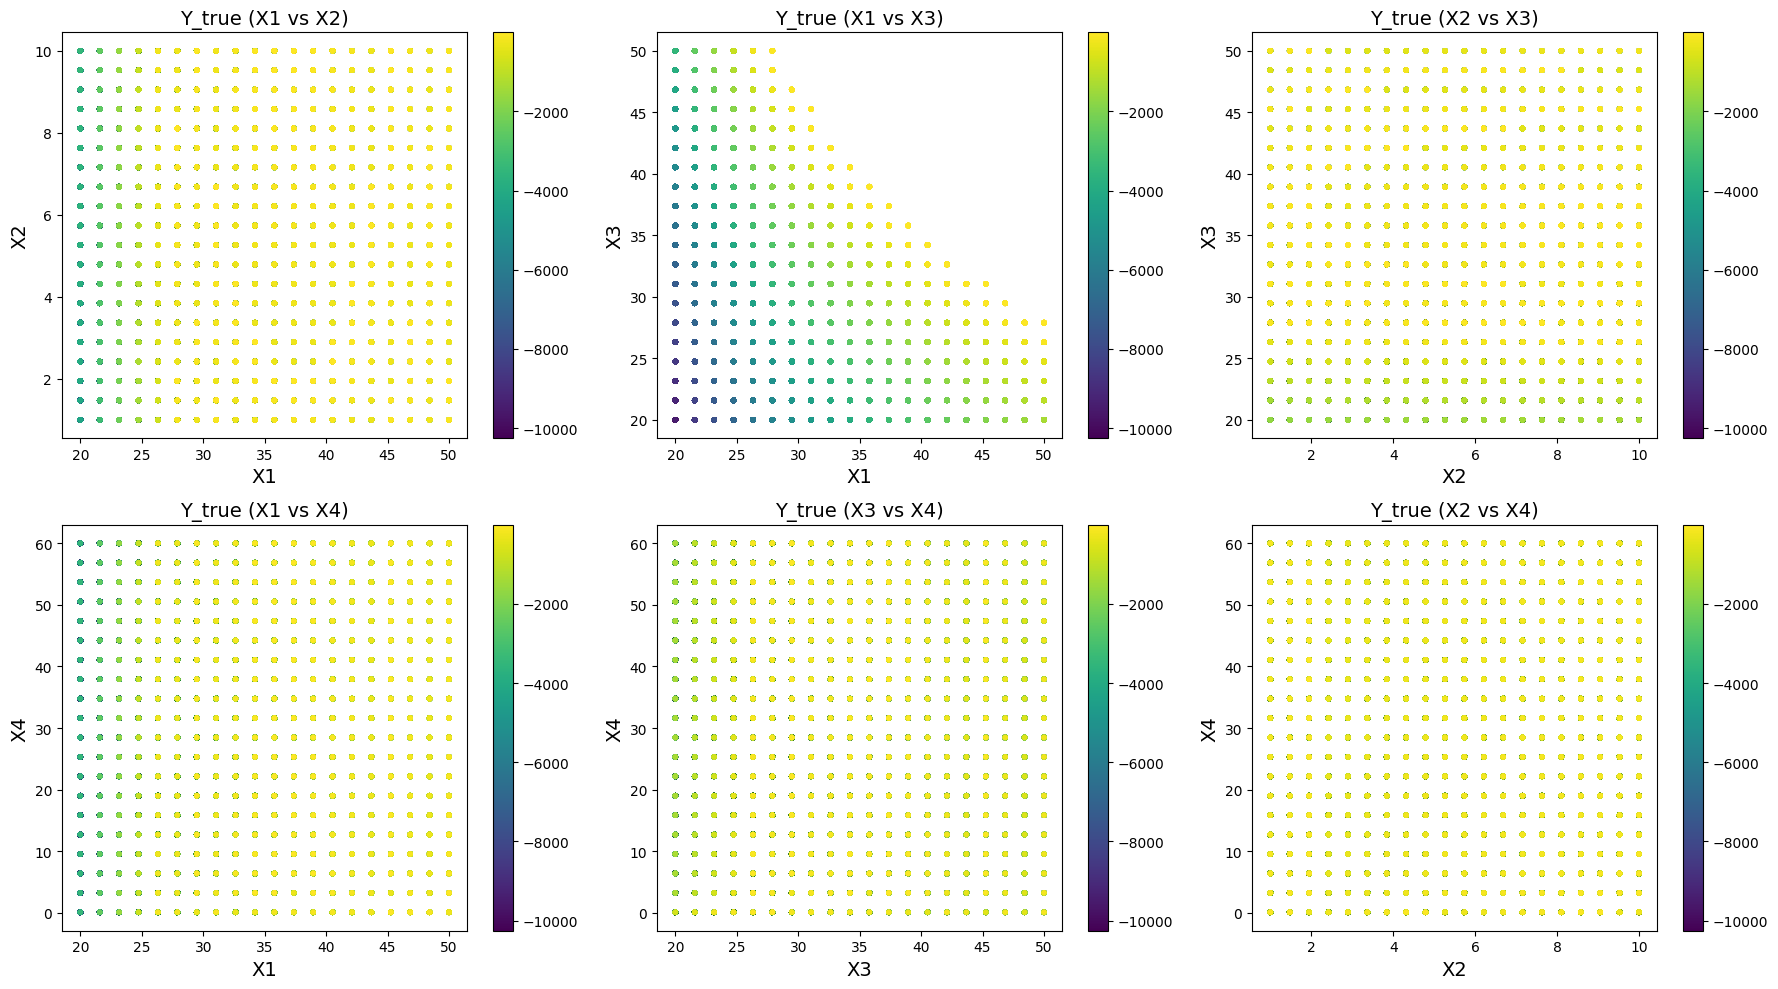

In [12]:
#cut through a point 2D plots

#2D plots
ptol = 20 #plots work just barely anything passess through 0
pp = 0 #NP = [35, 5, 35, 30] #midranges since that the NP explored 
# fm_X1 = ((df['Y_true'] <= 0 ) & ((df['X1'] < pp + ptol) & (df['X1'] > pp - ptol)))
# fm_X2 = ((df['Y_true'] <= 0 ) & ((df['X2'] < pp + ptol) & (df['X2'] > pp - ptol)))
# fm_X3 = ((df['Y_true'] <= 0 ) & ((df['X3'] < pp + ptol) & (df['X3'] > pp - ptol)))
# fm_X4 = ((df['Y_true'] <= 0 ) & ((df['X4'] < pp + ptol) & (df['X4'] > pp - ptol)))

fm_X1 = ((df['Y_true'] <= 0 ) & ((df['X1'] < 35 + ptol) & (df['X1'] > 35 - ptol)))
fm_X2 = ((df['Y_true'] <= 0 ) & ((df['X2'] < 5 + ptol) & (df['X2'] > 5 - ptol)))
fm_X3 = ((df['Y_true'] <= 0 ) & ((df['X3'] < 35 + ptol) & (df['X3'] > 35 - ptol)))
fm_X4 = ((df['Y_true'] <= 0 ) & ((df['X4'] < 30 + ptol) & (df['X4'] > 30 - ptol)))

fig, ax = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns layout for better visualization
fs = 14

# Plotting combinations for Y_true
sc1 = ax[0, 0].scatter(df['X1'][fm_X3 & fm_X4], df['X2'][fm_X3 & fm_X4], c=df['Y_true'][fm_X3 & fm_X4], marker='.', cmap='viridis')
cbar1 = fig.colorbar(sc1, ax=ax[0, 0])
ax[0, 0].set_title('Y_true (X1 vs X2)', fontsize=fs)
ax[0, 0].set_xlabel('X1', fontsize=fs)
ax[0, 0].set_ylabel('X2', fontsize=fs)
# ax[0, 0].set_xlim([-1,1])
# ax[0, 0].set_ylim([-1,1])

sc2 = ax[0, 1].scatter(df['X1'][fm_X2 & fm_X4], df['X3'][fm_X2 & fm_X4], c=df['Y_true'][fm_X2 & fm_X4], marker='.', cmap='viridis')
cbar2 = fig.colorbar(sc2, ax=ax[0, 1])
ax[0, 1].set_title('Y_true (X1 vs X3)', fontsize=fs)
ax[0, 1].set_xlabel('X1', fontsize=fs)
ax[0, 1].set_ylabel('X3', fontsize=fs)
# ax[0, 1].set_xlim([-1,1])
# ax[0, 1].set_ylim([-1,1])

sc3 = ax[0, 2].scatter(df['X2'][fm_X1 & fm_X4], df['X3'][fm_X1 & fm_X4], c=df['Y_true'][fm_X1 & fm_X4], marker='.', cmap='viridis')
cbar3 = fig.colorbar(sc3, ax=ax[0, 2])
ax[0, 2].set_title('Y_true (X2 vs X3)', fontsize=fs)
ax[0, 2].set_xlabel('X2', fontsize=fs)
ax[0, 2].set_ylabel('X3', fontsize=fs)
# ax[0, 2].set_xlim([-1,1])
# ax[0, 2].set_ylim([-1,1])

sc4 = ax[1, 0].scatter(df['X1'][fm_X3 & fm_X2], df['X4'][fm_X3 & fm_X2], c=df['Y_true'][fm_X3 & fm_X2], marker='.', cmap='viridis')
cbar1 = fig.colorbar(sc1, ax=ax[1, 0])
ax[1, 0].set_title('Y_true (X1 vs X4)', fontsize=fs)
ax[1, 0].set_xlabel('X1', fontsize=fs)
ax[1, 0].set_ylabel('X4', fontsize=fs)
# ax[1, 0].set_xlim([-1,1])
# ax[1, 0].set_ylim([-1,1])

sc5 = ax[1, 1].scatter(df['X3'][fm_X2 & fm_X1], df['X4'][fm_X2 & fm_X1], c=df['Y_true'][fm_X2 & fm_X1], marker='.', cmap='viridis')
cbar2 = fig.colorbar(sc2, ax=ax[1, 1])
ax[1, 1].set_title('Y_true (X3 vs X4)', fontsize=fs)
ax[1, 1].set_xlabel('X3', fontsize=fs)
ax[1, 1].set_ylabel('X4', fontsize=fs)
# ax[1, 1].set_xlim([-1,1])
# ax[1, 1].set_ylim([-1,1])

sc6 = ax[1, 2].scatter(df['X2'][fm_X1 & fm_X3], df['X4'][fm_X1 & fm_X3], c=df['Y_true'][fm_X1 & fm_X3], marker='.', cmap='viridis')
cbar3 = fig.colorbar(sc3, ax=ax[1, 2])
ax[1, 2].set_title('Y_true (X2 vs X4)', fontsize=fs)
ax[1, 2].set_xlabel('X2', fontsize=fs)
ax[1, 2].set_ylabel('X4', fontsize=fs)
# ax[1, 2].set_xlim([-1,1])
# ax[1, 2].set_ylim([-1,1])

plt.tight_layout()
plt.show()

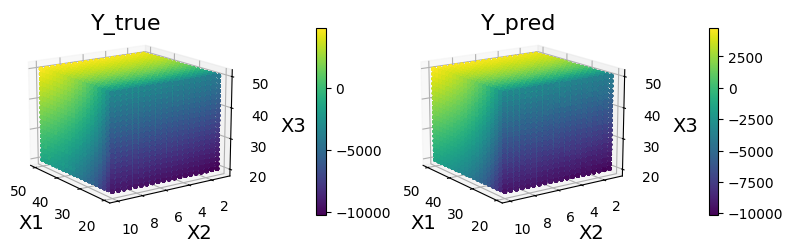

In [13]:
#3D plots with fixed X4

fs = 14
fig = plt.figure(figsize = (8, 3))
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
s1 = ax1.scatter(X1, X2, X3, c = Y_true, marker = '.')
cbar1 = fig.colorbar(s1, ax = ax1, fraction = 0.03, pad = 0.25)
ax1.view_init(15, 145)
ax1.set_title('Y_true', fontsize = fs + 2, y = 0.95)
ax1.set_xlabel('X1', fontsize = fs)
ax1.set_ylabel('X2', fontsize = fs)
ax1.set_zlabel('X3', fontsize = fs)

ax2 = fig.add_subplot(1, 2, 2, projection = '3d')
s2 = ax2.scatter(X1, X2, X3, c = Y_pred, marker = '.')
cbar2 = fig.colorbar(s2, ax = ax2, fraction = 0.03, pad = 0.25)
ax2.view_init(15, 145)
ax2.set_title('Y_pred', fontsize = fs + 2, y = 0.95)
ax2.set_xlabel('X1', fontsize = fs)
ax2.set_ylabel('X2', fontsize = fs)
ax2.set_zlabel('X3', fontsize = fs)


plt.tight_layout()
plt.show()

In [14]:

#GP model fucntion for slicing later
def GTCD(X):
    Y_pred, Y_pred_var = model.predict(X)
    X1 = np.array(X[:,0])
    X2 = np.array(X[:,1])
    X3 = np.array(X[:,2])
    X4 = np.array(X[:,3])
    Y_true = np.array(8.61 * np.exp(5) * X1**(1/2) * X2 * X3**(-2) * X4**(-1/2) +  3.69 * np.exp(4) * X3 + 7.72 * np.exp(8) * X1**(-1) * X2**0.219 - 765.43 * np.exp(6) * X1**(-1))

    X1_flat = X1.flatten()
    X2_flat = X2.flatten()
    X3_flat = X3.flatten()
    X4_flat = X4.flatten()
    Y_true_flat = Y_true.flatten()
    Y_pred_flat = Y_pred.flatten()

    # Create a DataFrame
    data = {
        'X1': X1_flat,
        'X2': X2_flat,
        'X3': X3_flat,
        'X4': X4_flat,
        'Y_true': Y_true_flat,
        'Y_pred': Y_pred_flat,
    }
    
    df = pd.DataFrame(data)
    df['G1'] = X4_flat * X2_flat**(-2) + X2_flat**(-2) - 1
    return df

In [15]:
#DSp with the slicing tool
from DSp_tools import generate_input_samples, save_pkl, load_pkl

#declaring the problem info 
# Global variables
maxvp = 0

#df['G1'] = X4_flat * X2_flat**(-2) + X2_flat**(-2) - 1
u = -0
cons = {'Y_pred': [-1e20, 0], 'G1': [-1e20, u]} 

#bounds = {'GTCD':    {'lb': [ ], 'ub': []}}
benchmark_problems = {'GTCD':    GTCD}
sv4D = ['X1', 'X2', 'X3', 'X4']
problem_sv = {'GTCD':    sv4D}


problem_list = ['GTCD']
#constant_vars_dict = {'GTCD': ['x2']} # specify which variables are constant
opt_hidedsp = {'hidedsp': True, 'hidevio': True}
no_samples = 4096
#no_slices = 1
benchmark_sol_4DGP = {} #benchmark_sol_4DGP

#nominal point for analysis
NP = [35, 5, 35, 30] #midranges

opt_find_DSp = {'hidedsp': False, 'opt_amul': True, 'maxvp': maxvp, 'tol': -1e5, 'ub': 1, 'lb': 0} #bisection run bounds

In [16]:
    
def get_Xconstliza(constant_dict, sv, lb, ub, no_samples, sampling_method, F_sam_plot):
    import numpy as np
    index_cut = []
    index_constant = []
    for l in sv:
        if l not in list(constant_dict.keys()):
            index_cut.append(sv.index(l))
        else:
            index_constant.append(sv.index(l))
    #print('getfun:const',index_constant, 'nonconst', index_cut)
    lb_cut = np.array(lb)[index_cut]
    ub_cut = np.array(ub)[index_cut]
    sv_cut = (np.array(sv)[index_cut]).tolist()
    #print('sv_cut', sv_cut)
    Xcut = Sobol_sequence(lb_cut, ub_cut)
    Xnew = np.zeros((Xcut.shape[0], len(sv)))
    Xnew[:, index_cut] = Xcut
    #print('Xnew before filling in constants', Xnew)
    Xnew[:, index_constant] = np.array([constant_dict[l] for l in list(constant_dict.keys())])
    #print('Xnew after filling in constants', Xnew)
    return Xnew, sv_cut

def get_slices_dfliza(no_slices, sv, lb, ub, no_samples, sampling_method, F_sam_plot, f, NP):
    import numpy as np
    import pandas as pd
    all_slices = []
    for slice_no in no_slices:
        #print('slice number',slice_no)
        constant_vars = [sv[slice_no]]
        ### ~ adapted to high D problem ~ ###
        #print('len(sv)',len(sv))
        if len(sv)>4:
            if slice_no < (len(sv)-1):
                constant_vars.append(sv[slice_no + 1])
            else:
                constant_vars.append(sv[0])
        #print('CONSTVAR',constant_vars)
        index_cut = []
        index_constant = []

        for l in sv:
            if l not in constant_vars:
                index_cut.append(sv.index(l))
            else:
                index_constant.append(sv.index(l))
        
        sv_constant = (np.array(sv)[index_constant]).tolist() 

        X_constant = (np.array(NP)[index_constant]).tolist() 
        #print('Xconst',X_constant)
        #print('sv', sv_constant)
        constant_dict = {}
        for i, l in enumerate(sv_constant):
            constant_dict[l] = X_constant[i]
            #print(constant_dict, X_constant)
        Xnew, sv_cut = get_Xconstliza(constant_dict, sv, lb, ub, no_samples, sampling_method, F_sam_plot)

        df = f(Xnew)
        df.insert(0, 'sv_cut', [sv_cut for i in range(df.shape[0])])
        df.insert(0, 'slice_no', slice_no)
        all_slices.append(df)
            
    all_slices = pd.concat(all_slices).reset_index(drop = True)
    return all_slices 

In [ ]:
#iterating through the slices


for problem_label in problem_list:
    print(problem_label)
    benchmark_sol_4DGP[problem_label] = {}
    f = benchmark_problems[problem_label]
    sv = problem_sv[problem_label]
    lb = xlimits[:,0]
    ub = xlimits[:,1]
    
    no_slices = range(len(sv))
    df_slices = get_slices_dfliza(no_slices, sv, lb, ub, no_samples, 'sobol', False, f, NP)
    for slice in no_slices:
        df = df_slices.copy()
        df = df[df['slice_no'] == slice]
        sv_slice = df['sv_cut'].iloc[0]
        
        ds = DSI(df)
        ds.screen(cons)
        ds.vnames = sv_slice
        ds.opt.update(opt_hidedsp)
        print(ds.df)
        if ds.sat.shape[0] == 0:
            print('No feasible points in slice ' + str(slice))
        else:
            #ds.find_DSp(sv_slice, opt = opt_find_DSp)
            #ds.plot(opt = {'hidevio': False})
            # Uncomment the above to find the DSp for each slice
            pass
        benchmark_sol_4DGP[problem_label][slice] = ds
save_pkl(benchmark_sol_4DGP, 'benchmark_sol_4DGP.pkl')

In [19]:
#metrics

benchmark_sol_4DGP = load_pkl('benchmark_sol_4DGP.pkl')

for no_slice in range(len(list(benchmark_sol_4DGP[problem_label].keys()))):
        print(no_slice)
        ds = benchmark_sol_4DGP[problem_label][no_slice]
        YpredFlag = np.array(ds.df['SatFlag'], dtype=int)
        Ytrue = np.array(ds.df['Y_true'])
        G1 = np.array(ds.df['G1'])
        YtrueFlag = np.where(((Ytrue >= cons['Y_pred'][0]) & (Ytrue <= cons['Y_pred'][1]) & (G1 >= cons['G1'][0]) & (G1 <= cons['G1'][1])), 1, 0)
        print(YtrueFlag)
        metrics = evaluate_metrics(YtrueFlag, YpredFlag)
        print(metrics)



Data loaded: benchmark_sol_4DGP.pkl
0
[0 0 1 ... 0 1 0]
[[5514    1]
 [   7 2670]]
{'Confusion Matrix': array([[5514,    1],
       [   7, 2670]], dtype=int64), 'Accuracy': 0.9990234375, 'Recall': 0.9990234375, 'Precision': 0.9990240919150187, 'F1 Score': 0.9990231551564992}
1
[1 0 1 ... 0 1 0]
[[6032    3]
 [   5 2152]]
{'Confusion Matrix': array([[6032,    3],
       [   5, 2152]], dtype=int64), 'Accuracy': 0.9990234375, 'Recall': 0.9990234375, 'Precision': 0.9990232998326589, 'F1 Score': 0.9990232919193058}
2
[0 0 0 ... 0 1 1]
[[5510    7]
 [   1 2674]]
{'Confusion Matrix': array([[5510,    7],
       [   1, 2674]], dtype=int64), 'Accuracy': 0.9990234375, 'Recall': 0.9990234375, 'Precision': 0.9990252169268454, 'F1 Score': 0.9990237188326871}
3
[0 0 0 ... 0 0 1]
[[5570    1]
 [   5 2616]]
{'Confusion Matrix': array([[5570,    1],
       [   5, 2616]], dtype=int64), 'Accuracy': 0.999267578125, 'Recall': 0.999267578125, 'Precision': 0.9992678294648725, 'F1 Score': 0.999267429891195}


Data loaded: benchmark_sol_4DGP.pkl
['X2', 'X3', 'X4']
Bisection search for alpha multiplier (radius)
    tol: 1.00e-03  maxiter: 50
    lb:  1.00e-30  ub:      5.00e+00
    maxvp: 0.00e+00  maxvnum: 0.00
____________________________________________________________________________________________
 No iter  |  alpha multiplier  |   Violation Flag   | Number vio inside  |   Bisection Gap    
____________________________________________________________________________________________
    1     |     2.500e+00      |        True        |        359         |     2.500e+00      
    2     |     1.250e+00      |        True        |        359         |     1.250e+00      
    3     |     6.250e-01      |        True        |        359         |     6.250e-01      
    4     |     3.125e-01      |        True        |        359         |     3.125e-01      
    5     |     1.562e-01      |        True        |        359         |     1.562e-01      
    6     |     7.812e-02      |       

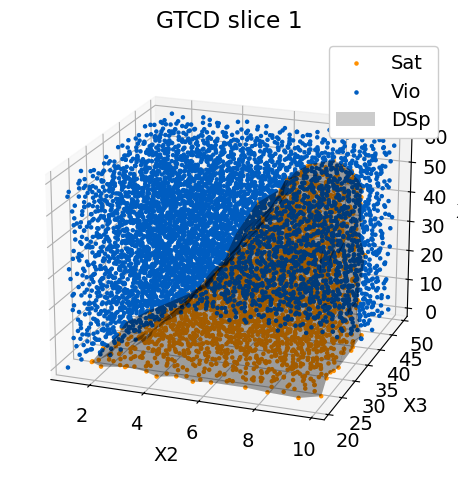

['X1', 'X3', 'X4']
Bisection search for alpha multiplier (radius)
    tol: 1.00e-03  maxiter: 50
    lb:  1.00e-30  ub:      5.00e+00
    maxvp: 0.00e+00  maxvnum: 0.00
____________________________________________________________________________________________
 No iter  |  alpha multiplier  |   Violation Flag   | Number vio inside  |   Bisection Gap    
____________________________________________________________________________________________
    1     |     2.500e+00      |        True        |        120         |     2.500e+00      
    2     |     1.250e+00      |        True        |        120         |     1.250e+00      
    3     |     6.250e-01      |        True        |        120         |     6.250e-01      
    4     |     3.125e-01      |        True        |        120         |     3.125e-01      
    5     |     1.562e-01      |        True        |        120         |     1.562e-01      
    6     |     7.812e-02      |        True        |        120         | 

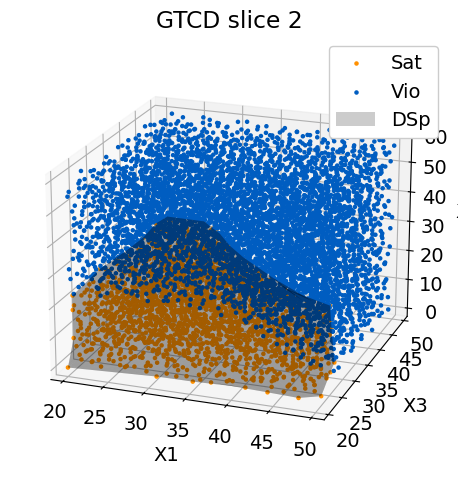

['X1', 'X2', 'X4']
Bisection search for alpha multiplier (radius)
    tol: 1.00e-03  maxiter: 50
    lb:  1.00e-30  ub:      5.00e+00
    maxvp: 0.00e+00  maxvnum: 0.00
____________________________________________________________________________________________
 No iter  |  alpha multiplier  |   Violation Flag   | Number vio inside  |   Bisection Gap    
____________________________________________________________________________________________
    1     |     2.500e+00      |        True        |        345         |     2.500e+00      
    2     |     1.250e+00      |        True        |        345         |     1.250e+00      
    3     |     6.250e-01      |        True        |        345         |     6.250e-01      
    4     |     3.125e-01      |        True        |        345         |     3.125e-01      
    5     |     1.562e-01      |        True        |        345         |     1.562e-01      
    6     |     7.812e-02      |        True        |        345         | 

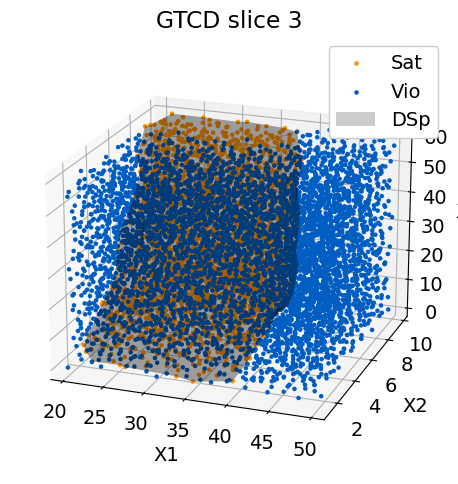

['X1', 'X2', 'X3']
Bisection search for alpha multiplier (radius)
    tol: 1.00e-03  maxiter: 50
    lb:  1.00e-30  ub:      5.00e+00
    maxvp: 0.00e+00  maxvnum: 0.00
____________________________________________________________________________________________
 No iter  |  alpha multiplier  |   Violation Flag   | Number vio inside  |   Bisection Gap    
____________________________________________________________________________________________
    1     |     2.500e+00      |        True        |        166         |     2.500e+00      
    2     |     1.250e+00      |        True        |        166         |     1.250e+00      
    3     |     6.250e-01      |        True        |        166         |     6.250e-01      
    4     |     3.125e-01      |        True        |        166         |     3.125e-01      
    5     |     1.562e-01      |        True        |        166         |     1.562e-01      
    6     |     7.812e-02      |        True        |        166         | 

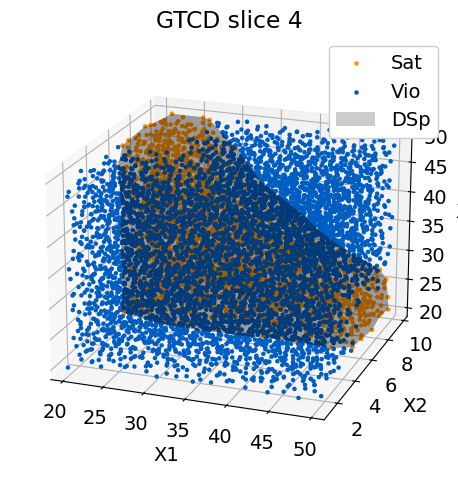

In [20]:
#plotting the results
benchmark_sol_4DGP = load_pkl('benchmark_sol_4DGP.pkl')

for problem_label in ['GTCD']:
    for no_slice in range(len(list(benchmark_sol_4DGP[problem_label].keys()))):
        opt_hidedsp = {'hidedsp': False, 'hidevio': False}
        ds = benchmark_sol_4DGP[problem_label][no_slice]
        sv = ds.df['sv_cut'].iloc[0]
        print(sv)
        ds.plot(sv, opt = opt_hidedsp)
        plt.title(problem_label + ' slice ' + str(no_slice+1))
        plt.show()